## Параметрические критерии

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import scipy
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**1.** В одном из выпусков программы "Разрушители легенд" проверялось, действительно ли заразительна зевота. В эксперименте участвовало 50 испытуемых, проходивших собеседование на программу. Каждый из них разговаривал с рекрутером; в конце 34 из 50 бесед рекрутер зевал. Затем испытуемых просили подождать решения рекрутера в соседней пустой комнате. 

Во время ожидания 10 из 34 испытуемых экспериментальной группы и 4 из 16 испытуемых контрольной начали зевать. Таким образом, разница в доле зевающих людей в этих двух группах составила примерно 4.4%. Ведущие заключили, что миф о заразительности зевоты подтверждён. 

Можно ли утверждать, что доли зевающих в контрольной и экспериментальной группах отличаются статистически значимо? Посчитайте достигаемый уровень значимости при альтернативе заразительности зевоты, округлите до четырёх знаков после десятичной точки.

### Z-критерий для разности долей (независимые выборки)
Suc | $X_1$ | $X_2$  
--- | --- | ----|
  1  | $a$ | $b$ 
  0  | $c$ | $d$ 
  $\sum$ | $n_1$| $n_2$
  
$$ \hat{p}_1 = \frac{a}{n_1}$$

$$ \hat{p}_2 = \frac{b}{n_2}$$


$$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

$$Z-статистика: Z({X_1, X_2}) =  \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{P(1 - P)(\frac{1}{n_1} + \frac{1}{n_2})}}$$
$$P = \frac{\hat{p}_1{n_1} + \hat{p}_2{n_2}}{{n_1} + {n_2}} $$

In [2]:
n1 = 34 
suc1 = 10
n2 = 16
suc2 = 4

p1 = suc1 / n1 
p2 = suc2 / n2

In [3]:
alpha = 0.05
z = scipy.stats.norm.ppf(1 - alpha / 2.)   

left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ n1 + p2 * (1 - p2)/ n2)
right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ n1 + p2 * (1 - p2)/ n2)
print(f'Confidence interval: {[round(x, 4) for x in [left_boundary, right_boundary]]}')

Confidence interval: [-0.2176, 0.3058]


In [4]:
P = (p1 * n1 + p2 * n2) / (n1 + n2)
Z = (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [5]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [6]:
print(f"p-value: {round(proportions_diff_z_test(Z, 'greater'), 4)}")

p-value: 0.3729


**Вывод:** Урвовень значимости > 0.05 доли зевающих в контрольной и экспериментальной группах не отличаются статистически значимо 

**2.** Имеются данные измерений двухсот швейцарских тысячефранковых банкнот, бывших в обращении в первой половине XX века. Сто из банкнот были настоящими, и сто — поддельными. На рисунке ниже показаны измеренные признаки:
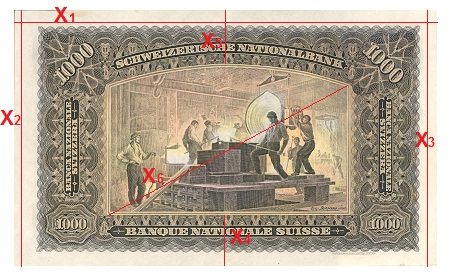
Отделите 50 случайных наблюдений в тестовую выборку с помощью функции sklearn.cross_validation.train_test_split (зафиксируйте random state = 1). На оставшихся 150 настройте два классификатора поддельности банкнот:

1. логистическая регрессия по признакам $X_1,X_2,X_3$

1. логистическая регрессия по признакам $X_4,X_5,X_6$ 

Каждым из классификаторов сделайте предсказания меток классов на тестовой выборке. Одинаковы ли доли ошибочных предсказаний двух классификаторов? Проверьте гипотезу, вычислите достигаемый уровень значимости. Введите номер первой значащей цифры (например, если вы получили $5.5\times10^{-8}$, нужно ввести 8).

In [7]:
data = pd.read_csv('data/banknotes.txt', sep = '\t')
data.head()

,X1,X2,X3,X4,X5,X6,real
0,214.8,131.0,131.1,9.0,9.7,141.0,1
1,214.6,129.7,129.7,8.1,9.5,141.7,1
2,214.8,129.7,129.7,8.7,9.6,142.2,1
3,214.8,129.7,129.6,7.5,10.4,142.0,1
4,215.0,129.6,129.7,10.4,7.7,141.8,1


In [8]:
y = data.real
X = data.drop('real', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=50, random_state=1)

In [9]:
lr1 = LogisticRegression()
lr2 = LogisticRegression()
lr1.fit(X_train[['X1', 'X2', 'X3']], y_train)
lr2.fit(X_train[['X4', 'X5', 'X6']], y_train)
lr1_pred = lr1.predict(X_test[['X1', 'X2', 'X3']])
lr2_pred = lr2.predict(X_test[['X4', 'X5', 'X6']])

In [10]:
lr1_pred_error = np.sum(y_test != lr1_pred)/lr1_pred.shape
lr2_pred_error = np.sum(y_test != lr2_pred)/lr2_pred.shape
print(f"Error rate of first LogisticRegression: {lr1_pred_error[0]}")
print(f"Error rate of second LogisticRegression: {lr2_pred_error[0]}")

Error rate of first LogisticRegression: 0.2
Error rate of second LogisticRegression: 0.02


In [11]:
lr1_pred_res = lr1_pred == y_test 
lr2_pred_res = lr2_pred == y_test 

In [12]:
p1 = lr1_pred_error[0]
p2 = lr2_pred_error[0]
n = 50
P = (p1 * n + p2 * n) / (n + n)
Z = (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n + 1. / n))
print(f"p-value: {round(proportions_diff_z_test(Z), 4)}")

p-value: 0.004


**3.** В предыдущей задаче посчитайте 95% доверительный интервал для разности долей ошибок двух классификаторов. Чему равна его ближайшая к нулю граница? Округлите до четырёх знаков после десятичной точки.

In [13]:
alpha = 0.05
z = scipy.stats.norm.ppf(1 - alpha / 2.) 

left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ n + p2 * (1 - p2)/ n)
right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ n + p2 * (1 - p2)/ n)
print(f'Confidence interval: {[round(x, 4) for x in [left_boundary, right_boundary]]}')

Confidence interval: [0.0625, 0.2975]


## Z-критерий для разности долей (связанные выборки) 
$X_1\X_2$ | $1$    | $0$     | $\sum$ |
------------ |------ |------- |-------- |
 $1$  | $e$   | $f$  | $e + f$
 $0$  | $g$    | $h$     | $g + h$
 $\sum$ |$e + g$| $f + h$ | $n$ 
  
$$ \hat{p}_1 = \frac{e + f}{n}$$

$$ \hat{p}_2 = \frac{e + g}{n}$$

$$ \hat{p}_1 - \hat{p}_2 = \frac{f - g}{n}$$


$$\text{Доверительный интервал для }p_1 - p_2\colon \;\;  \frac{f - g}{n} \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{f + g}{n^2} - \frac{(f - g)^2}{n^3}}$$

$$Z-статистика: Z({X_1, X_2}) = \frac{f - g}{\sqrt{f + g - \frac{(f-g)^2}{n}}}$$

In [14]:
def proportions_diff_z_stat_rel(sample1, sample2):
    sample = list(zip(sample1, sample2))
    n = len(sample)
    
    f = sum([1 if (x[0] == 1 and x[1] == 0) else 0 for x in sample])
    g = sum([1 if (x[0] == 0 and x[1] == 1) else 0 for x in sample])
    
    return float(f - g) / np.sqrt(f + g - float((f - g)**2) / n )

p_value = proportions_diff_z_test(proportions_diff_z_stat_rel(lr1_pred_res, lr2_pred_res))
print(f'p-value: {p_value}')

p-value: 0.0009231887438696518


In [15]:
def proportions_diff_confint_rel(sample1, sample2, alpha = 0.05):
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    sample = list(zip(sample1, sample2))
    n = len(sample)
        
    f = sum([1 if (x[0] == 1 and x[1] == 0) else 0 for x in sample])
    g = sum([1 if (x[0] == 0 and x[1] == 1) else 0 for x in sample])
    
    left_boundary = float(f - g) / n  - z * np.sqrt(float((f + g)) / n**2 - float((f - g)**2) / n**3)
    right_boundary = float(f - g) / n  + z * np.sqrt(float((f + g)) / n**2 - float((f - g)**2) / n**3)
    return (left_boundary, right_boundary)

In [16]:
proportions_diff_confint_rel(lr1_pred_res, lr2_pred_res)

(-0.2864893724213316, -0.0735106275786684)

In [17]:
print(f"confidence interval: {list(map(lambda x: round(x, 4), proportions_diff_confint_rel(lr1_pred_res, lr2_pred_res)))}")

confidence interval: [-0.2865, -0.0735]


**4.** Ежегодно более 200000 людей по всему миру сдают стандартизированный экзамен GMAT при поступлении на программы MBA. Средний результат составляет 525 баллов, стандартное отклонение — 100 баллов. 

Сто студентов закончили специальные подготовительные курсы и сдали экзамен. Средний полученный ими балл — 541.4. Проверьте гипотезу о неэффективности программы против односторонней альтернативы о том, что программа работает. Отвергается ли на уровне значимости 0.05 нулевая гипотеза? Введите достигаемый уровень значимости, округлённый до 4 знаков после десятичной точки. 

In [18]:
n = 200000.
mu = 525.
std = 100.
n_course = 100.
mean_course = 541.4

In [19]:
Z = (mean_course - mu) / (std / np.sqrt(n_course))
p_value = 1-scipy.stats.norm.cdf(Z)
print(f'p-value = {round(p_value, 4)}')

p-value = 0.0505


**Вывод:** Уровень значимости незначительно больше 0.05, нулевая гипотеза не отвергается, программа неэффктивна.

**5.** Оцените теперь эффективность подготовительных курсов, средний балл 100 выпускников которых равен 541.5. Отвергается ли на уровне значимости 0.05 та же самая нулевая гипотеза против той же самой альтернативы? Введите достигаемый уровень значимости, округлённый до 4 знаков после десятичной точки. 

In [20]:
mean_course_2 = 541.5
Z_2 = (mean_course_2 - mu) / (std / np.sqrt(n_course))
p_value_2 = 1-scipy.stats.norm.cdf(Z_2)
print(f'p-value = {round(p_value_2, 4)}')

p-value = 0.0495


**Вывод:** Уровень значимости незначительно меньше 0.05, нулевая гипотеза отвергается, программа эффктивна.